<a href="https://colab.research.google.com/github/RubSevian/Learn_RL_Cource/blob/main/homeworks/hw03_qlearning/01_qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## HW 3: Q-learning
_Reference: based on Practical RL course by YSDA_

In this notebook you have to master Q-learning and apply it to RL problems once again.

To get used to `gymnasium` package, please, refer to the [documentation](https://gymnasium.farama.org/introduction/basic_usage/).


In the end of the notebook, please, copy the functions you have implemented to the template file and submit it to the Contest.

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Step 1: Tabular Q-learning with SoftMax policy

We want you to implement Q-learning algorithm with softmax policy.

You need to implement QLearningAgent (follow instructions for each method) and use it on a number of tests below.

SoftMax policy means that actions probabilities are computed from q-values using softmax function, where $\tau$ is the softmax temperature:

$$ \pi(a_i \mid s) = \operatorname{softmax} \left( \left\{ {Q(s, a_j) \over \tau} \right\}_{j=1}^n \right)_i = {\operatorname{exp} \left( Q(s,a_i) / \tau \right)  \over {\sum_{j}  \operatorname{exp} \left( Q(s,a_j) / \tau  \right)}} $$

First, implement softmax. Do not forget that exponent of large value might be too big to fit in float. Substract maximum for numerical stability.

Разбор задания
Тебе нужно реализовать функцию my_softmax, которая:

Принимает массив values (например, Q-значения для состояния) и параметр температуры T (по умолчанию 1.0).
Вычисляет вероятности по формуле SoftMax:
$$\pi(a_i) = \frac{\exp(v_i / T)}{\sum_j \exp(v_j / T)}$$
где $v_i$ — элементы массива values.
Учитывает числовую стабильность: вычитает максимальное значение из values перед применением экспоненты, чтобы избежать переполнения при больших значениях.
Возвращает массив вероятностей probas, где сумма элементов равна 1.

Почему нужна численная стабильность:

Экспонента (np.exp) для больших значений (например, 1000) может дать огромные числа, что приведёт к переполнению или неточности в вычислениях.
Чтобы этого избежать, вычитаем максимальное значение $M = \max(values)$ из всех элементов:
$$\exp(v_i / T) = \exp((v_i - M) / T) \cdot \exp(M / T)$$
При делении в SoftMax $\exp(M / T)$ сокращается, и результат остаётся тем же, но вычисления стабильнее.

Проверка:

Твой код сравнивает my_softmax с torch.softmax для test_data = np.arange(5) и разных температур T = [0.1, 0.5, 1, 5]. Это значит, что твоя реализация должна давать такие же результаты, как torch.softmax.



Шаг 1: Понимание SoftMax
Формула SoftMax:
$$\text{probas}_i = \frac{\exp(v_i / T)}{\sum_j \exp(v_j / T)}$$

values — входной массив, например, [0, 1, 2, 3, 4] для test_data = np.arange(5).
T — температура, которая контролирует "мягкость" распределения:

Маленькое T (например, 0.1) делает вероятности ближе к 0 или 1 (жадная политика).
Большое T (например, 5) делает вероятности более равномерными.


Для численной стабильности:

Найди $M = \max(values)$.
Вычисли $\exp((v_i - M) / T)$ вместо $\exp(v_i / T)$.
Нормализуй, разделив на сумму.





Шаг 2: Реализация my_softmax
Давай реализуем функцию. Вот шаги:

Найди максимальное значение в values с помощью np.max(values).

Раздели values на T и вычти максимум: (values - max_value) / T.

Примени экспоненту: np.exp(...).

Нормализуй, разделив на сумму: exp_values / np.sum(exp_values).

Верни массив вероятностей.

Подсказка:

Используй np.max, np.exp, np.sum.
Убедись, что результат — массив той же длины, что values, и сумма элементов равна 1.

In [3]:
def my_softmax(values: np.ndarray, T=1.):
    max_values = np.max(values)
    exp_values = (np.exp((values-max_values)/T))*np.exp(max_values/T)

    probas = exp_values/np.sum(exp_values)
    assert probas is not None
    return probas

Now check your Softmax using the following tests.

In [4]:
import torch
test_data = np.arange(5)
for temp in [0.1, 0.5, 1, 5]:
  local_softmax = my_softmax(test_data, T=temp)
  with torch.no_grad():
    torch_softmax = torch.softmax(torch.from_numpy(test_data)/temp, dim=-1)
  assert np.allclose(local_softmax, torch_softmax.numpy())
  print(f'Passed for temp={temp}')

Passed for temp=0.1
Passed for temp=0.5
Passed for temp=1
Passed for temp=5


Simple visualization for your convenience

Text(0.5, 1.0, 'Example softmax with temp = 1')

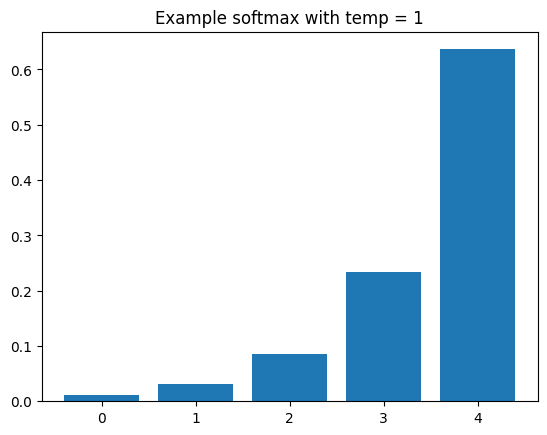

In [5]:
temp = 1
plt.bar(test_data, my_softmax(test_data, T=temp))
plt.title(f'Example softmax with temp = {temp}')

Now implement the `QLearningAgent`. You will solve several environments using it and later submit to the Contest.

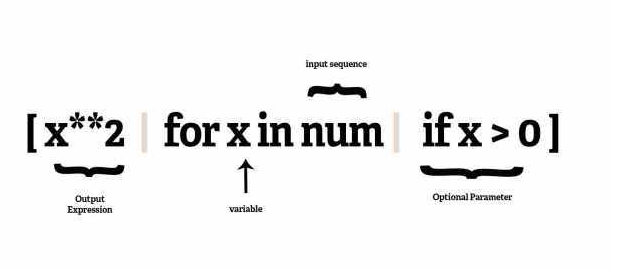

Шаг 1: Реализация get_value
Этот метод вычисляет ценность состояния $V(s)$ как максимальное Q-значение среди всех допустимых действий:
$$V(s) = \max_{a \in \text{legal actions}} Q(s, a)$$
Если нет допустимых действий, возвращается 0.0.
Шаги:

Получи список допустимых действий: self.get_legal_actions(state).
Если действий нет, верни 0.0 (уже есть в коде).
Для каждого действия получи Q-значение с помощью self.get_qvalue(state, action).
Найди максимум с помощью max.

Шаг 2: Реализация update
Этот метод обновляет Q-значение для пары (state, action) по формуле:
$$Q(s, a) \leftarrow (1 - \alpha) Q(s, a) + \alpha (r + \gamma V(s'))$$
где $V(s')$ — ценность следующего состояния, вычисленная с помощью get_value.
Шаги:

Получи текущие параметры: self.alpha, self.discount, reward, next_state.
Вычисли $V(s')$ с помощью self.get_value(next_state).
Вычисли новое Q-значение:
$$qvalue = (1 - \alpha) \cdot Q(s, a) + \alpha \cdot (r + \gamma \cdot V(s'))$$

Установи новое Q-значение с помощью self.set_qvalue(state, action, qvalue).

Шаг 3: Реализация get_best_action
Этот метод выбирает действие с максимальным Q-значением для состояния state.
Шаги:

Получи допустимые действия: self.get_legal_actions(state).
Если действий нет, верни None (уже есть в коде).
Для каждого действия получи Q-значение.
Найди действие с максимальным Q-значением (можно использовать max с ключом).

Шаг 4: Реализация get_softmax_policy
Этот метод вычисляет вероятности действий с помощью SoftMax, используя твою функцию my_softmax из предыдущего шага:
$$p(a_i \mid s) = \text{softmax}([Q(s, a_1), Q(s, a_2), \dots])_i$$
Шаги:

Получи допустимые действия: self.get_legal_actions(state).
Если действий нет, верни None (уже есть в коде).
Собери Q-значения для всех допустимых действий: [self.get_qvalue(state, a) for a in possible_actions].
Преобразуй их в массив np.array.
Примени my_softmax с температурой self.temp.

Шаг 5: Реализация get_action
Этот метод выбирает действие согласно SoftMax-политике, используя вероятности из get_softmax_policy.
Шаги:

Получи допустимые действия: self.get_legal_actions(state).
Если действий нет, верни None (уже есть в коде).
Получи вероятности с помощью self.get_softmax_policy(state).
Выбери действие с помощью np.random.choice(possible_actions, p=probabilities).

Что такое $ V(s) $ и $ V(s') $?
В контексте Q-learning:

$ V(s) $ — это ценность состояния $ s $, которая показывает, насколько "хорошо" находиться в состоянии $ s $, если следовать текущей политике. В Q-learning ценность состояния определяется как максимальное Q-значение среди всех возможных действий в этом состоянии:
$$V(s) = \max_{a} Q(s, a)$$
То есть, $ V(s) $ — это оценка максимальной будущей награды, которую можно получить, начав из состояния $ s $ и выбрав лучшее действие.
$ V(s') $ — это ценность следующего состояния $ s' $, в которое мы переходим после выполнения действия $ a $ в состоянии $ s $. Она тоже вычисляется как:
$$V(s') = \max_{a'} Q(s', a')$$
Здесь $ a' $ — это возможные действия в следующем состоянии $ s' $.

Почему $ V(s') $?
В формуле обновления Q-learning:
$$Q(s, a) \leftarrow (1 - \alpha) Q(s, a) + \alpha (r + \gamma V(s'))$$

$ r $ — награда, полученная за действие $ a $ в состоянии $ s $.
$ \gamma $ — коэффициент дисконтирования (например, 0.99), который уменьшает ценность будущих наград.
$ V(s') $ — это оценка будущей награды, если мы будем действовать оптимально, начиная из следующего состояния $ s' $.
$ V(s') = \max_{a'} Q(s', a') $, потому что мы предполагаем, что в следующем состоянии $ s' $ агент выберет лучшее действие (с максимальным Q-значением).

Пример для ясности
Допустим, ты в окружении Taxi-v3:

Состояние $ s = 42 $, действие $ a = 0 $ (вверх).
Выполняешь действие, получаешь: $ r = -1 $, $ next_state = 43 $, $ done = False $.
Параметры: $ \alpha = 0.1 $, $ \gamma = 0.99 $.

Шаг 1: Вычисли $ V(s') $:

Допустимые действия в $ s' = 43 $: [0, 1, 2, 3, 4, 5].
Q-значения: Q(43, 0) = 5.0, Q(43, 1) = 4.0, ..., Q(43, 5) = 3.0.
$ V(s') = \max(Q(43, a')) = \max(5.0, 4.0, ..., 3.0) = 5.0 $.

Шаг 2: Обнови $ Q(s, a) $:

Текущее $ Q(s, a) = Q(42, 0) = 2.0 $.
Целевое значение: $ r + \gamma V(s') = -1 + 0.99 \cdot 5.0 = -1 + 4.95 = 3.95 $.
Новое Q-значение:
$$Q(42, 0) \leftarrow (1 - 0.1) \cdot 2.0 + 0.1 \cdot 3.95 = 0.9 \cdot 2.0 + 0.1 \cdot 3.95 = 1.8 + 0.395 = 2.195$$

Установи: self.set_qvalue(42, 0, 2.195).

In [6]:
import random
from collections import defaultdict


class QLearningAgent:
    def __init__(self, alpha, discount, get_legal_actions, temp=1.):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)
          - self.temp (softmax temperature)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly.
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.discount = discount
        self.temp = temp

    def get_qvalue(self, state, action):
        """Returns Q(state,action)"""
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """Sets the Qvalue for [state,action] to the given value"""
        self._qvalues[state][action] = value

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        # YOUR CODE HERE
        # Calculate the approximation of value function V(s).
        value = max(self.get_qvalue(state,action) for action in possible_actions)
        assert value is not None

        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        # YOUR CODE HERE
        # Calculate the updated value of Q(s, a).
        current_value_q = self.get_qvalue(state, action)
        next_value = self.get_value(next_state)
        qvalue = (1-learning_rate)*current_value_q + learning_rate*(reward+gamma*next_value)

        assert qvalue is not None

        self.set_qvalue(state, action, qvalue)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values).
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # YOUR CODE HERE
        # Choose the best action wrt the qvalues.

        best_action = max(possible_actions , key=lambda a: self.get_qvalue(state,a))
        assert best_action is not None

        return best_action

    def get_softmax_policy(self, state):
        """
        Compute all actions probabilities in the current state according
        to their q-values using softmax policy.

        Actions probability should be computed as
        p(a_i|s) = softmax([q(s, a_1), q(s, a_2), ... q(s, a_k)])_i
        Softmax temperature is set to `self.temp`.
        See the formula in the notebook for more details
        """
        possible_actions = self.get_legal_actions(state)
        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # YOUR CODE HERE
        # Compute all actions probabilities in the current state using softmax
        q_values = np.array([self.get_qvalue(state,a)for a in possible_actions])
        assert q_values is not None
        probabilities = my_softmax(q_values,T=self.temp)
        assert probabilities is not None

        return probabilities


    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.
        Select actions according to softmax policy.

        Note: To pick randomly from a list, use np.random.choice(..., p=actions_probabilities)
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """
        possible_actions = self.get_legal_actions(state)
        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # YOUR CODE HERE
        # Select the action to take in the current state according to the policy
        proba = self.get_softmax_policy(state)
        chosen_action = np.random.choice(possible_actions,p=proba)
        assert chosen_action is not None
        return chosen_action

Функция max в Python находит максимальный элемент в списке, но с параметром key она позволяет указать, по какому критерию сравнивать элементы. Давай разберём, как это работает в твоём коде.

Аргументы функции max:

possible_actions: Это список допустимых действий для состояния state, например, [0, 1, 2, 3, 4, 5] в Taxi-v3 (действия: вверх, вниз, влево, вправо, забрать, высадить).
key=lambda a: self.get_qvalue(state, a): Это функция, которая для каждого действия a возвращает его Q-значение $ Q(s, a) $, полученное через self.get_qvalue(state, a).


Как работает key:

Параметр key говорит max, по какому значению сравнивать элементы списка possible_actions.
Здесь key=lambda a: self.get_qvalue(state, a) означает, что для каждого действия a из possible_actions мы вычисляем $ Q(s, a) $, и max выбирает то действие, у которого $ Q(s, a) $ наибольшее.


Результат:

max(possible_actions, key=...) возвращает действие (элемент из possible_actions), у которого Q-значение максимально.
Это и есть "лучшее действие" для состояния state, так как в Q-learning лучшее действие — то, которое имеет наибольшее $ Q(s, a) $.

Давай свяжем твоё понимание с кодом:

Оценка состояния:

В методе get_value ты вычисляешь $ V(s) = \max_{a} Q(s, a) $, чтобы понять, насколько хорошее текущее состояние.

В get_softmax_policy ты используешь Q-значения, чтобы распределить вероятности действий:

q_values = np.array([self.get_qvalue(state, a) for a in possible_actions])

probabilities = my_softmax(q_values, T=self.temp)



Выбор действия:

В get_action ты выбираешь действие с учётом исследования (SoftMax даёт шанс попробовать не только лучшее действие):

chosen_action = np.random.choice(possible_actions, p=proba)

Это позволяет учиться на "ошибках", пробуя разные действия.


Переход и обновление:

В play_and_train ты выполняешь действие, получаешь $ r $ и $ s' $, затем обновляешь $ Q(s, a) $:

a = agent.get_action(s)

next_s, r, done, _, _ = env.step(a)

agent.update(s, a, r, next_s, done)

Обновление корректирует $ Q(s, a) $, чтобы оно лучше предсказывало будущую награду.


Учимся предсказывать:

С каждым эпизодом Q-таблица становится точнее, потому что ты обновляешь её на основе реального опыта.
В Taxi-v3 агент учится доставлять пассажира за минимальное число шагов.
В CartPole-v1 агент учится балансировать шест, максимизируя число шагов.

Что такое Q-learning и в чём его "прикол"?
Q-learning — это алгоритм обучения с подкреплением (Reinforcement Learning), который помогает агенту научиться принимать решения, максимизирующие кумулятивную награду в будущем. "Прикол" в том, что он:

Учитывает не только текущую награду, но и будущие:

Q-learning оценивает, насколько хорошим является действие $ a $ в состоянии $ s $, не только по немедленной награде $ r $, но и по тому, какие награды можно получить в будущем, если продолжать действовать оптимально.


Учится методом проб и ошибок:

Агент пробует разные действия, получает награды и обновляет свои оценки (Q-значения), чтобы постепенно понимать, какие действия приводят к большим наградам.


Не требует модели среды:

В отличие от других методов, Q-learning работает без знания, как устроена среда (например, каковы вероятности переходов между состояниями). Он учится только на основе опыта: состояние $ s $, действие $ a $, награда $ r $, следующее состояние $ s' $.


Обновляет предсказания:

Q-значение $ Q(s, a) $ — это оценка ожидаемой кумулятивной награды, если выбрать действие $ a $ в состоянии $ s $ и продолжать действовать оптимально. Q-learning корректирует эти оценки, чтобы они становились точнее на основе реального опыта.



Ключевой момент: Q-learning учит агента предсказывать долгосрочную ценность действия $ a $ в состоянии $ s $, а не только немедленную награду. Это позволяет агенту находить стратегию, которая максимизирует общую награду за эпизод.

### ИТОГ
Утверждение:
В Q-learning мы сначала оцениваем текущее состояние $ s $, определяя его ценность $ V(s) $ как максимальное Q-значение среди всех возможных действий ($ V(s) = \max_a Q(s, a) $). Затем мы выбираем действие $ a $, которое с высокой вероятностью приведёт к большей кумулятивной награде, используя, например, SoftMax-политику, чтобы балансировать между исследованием новых действий и выбором уже известных лучших. После выполнения действия мы переходим в новое состояние $ s' $, получаем награду $ r $ и оцениваем ценность этого нового состояния $ V(s') = \max_{a'} Q(s', a') $. Используя эту информацию, мы обновляем $ Q(s, a) $, корректируя наше предсказание о том, насколько действие $ a $ в состоянии $ s $ выгодно, с учётом реальной награды $ r $ и будущей ценности $ V(s') $. Таким образом, мы учим алгоритм предсказывать будущую кумулятивную награду, улучшая оценки $ Q(s, a) $ на основе опыта — прошлых успехов и ошибок.

### Try it on taxi

Here we use the Q-Learning agent on the Taxi-v3 environment from OpenAI gym.
You will need to complete a few of its functions.

In [7]:
import gymnasium as gym

env = gym.make("Taxi-v3", render_mode="rgb_array")

n_actions = env.action_space.n

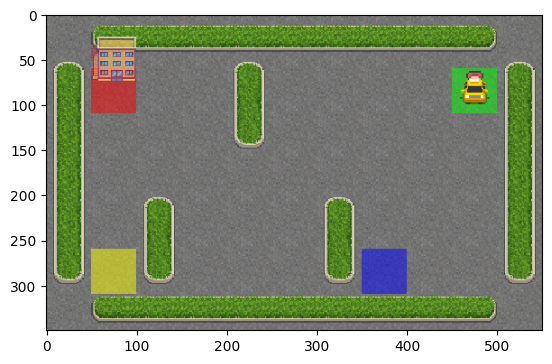

In [8]:
s, _ = env.reset()
plt.imshow(env.render())

In [9]:
agent = QLearningAgent(alpha=0.5, discount=0.99, get_legal_actions=lambda s: range(n_actions))

In [10]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function should
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s, _ = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)

        next_s, r, done, _, _ = env.step(a)

        # train (update) agent for state s
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

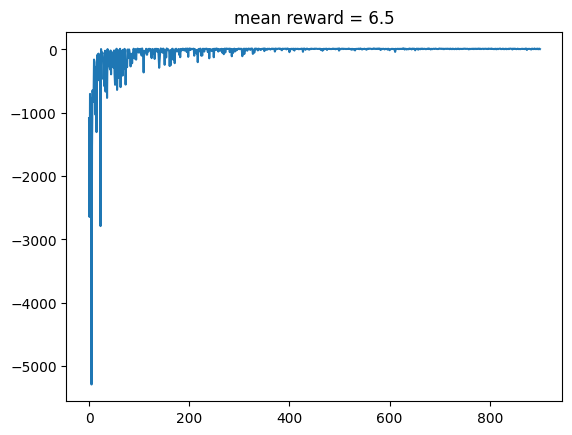

In [11]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))

    if i % 100 == 0:
        clear_output(True)
        plt.title("mean reward = {:.1f}".format(np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.show()

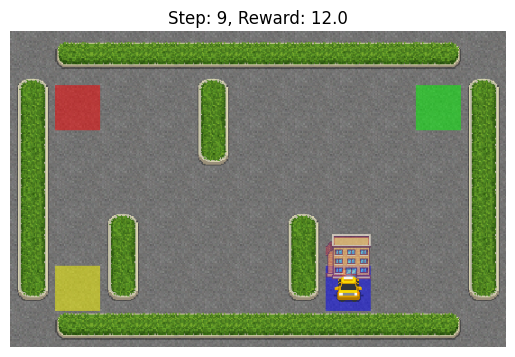

Total Reward: 12.0, Steps: 9


In [12]:
# Функция для визуализации жадной политики
import time
def play_visualize(env, agent, t_max=1000):
    total_reward = 0.0
    steps = 0
    s, _ = env.reset()

    for t in range(t_max):
        a = agent.get_best_action(s)  # Жадная политика для лучшего поведения
        next_s, r, done, truncated, _ = env.step(a)
        total_reward += r
        steps += 1
        s = next_s

        # Визуализация в Colab
        plt.imshow(env.render())  # Получаем кадр как RGB-массив
        plt.axis('off')
        plt.title(f"Step: {steps}, Reward: {total_reward:.1f}")
        clear_output(wait=True)
        plt.show()
        time.sleep(0.5)  # Задержка 0.5 секунды для анимации

        if done or truncated:
            break

    return total_reward, steps
# Создаём окружение и агента
env = gym.make('Taxi-v3', render_mode="rgb_array")
n_actions = env.action_space.n

def get_legal_actions(state):
    return list(range(n_actions))

agent = QLearningAgent(alpha=0.1, discount=0.99, get_legal_actions=get_legal_actions, temp=1.0)

# Цикл обучения
rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    if i % 100 == 0:
        clear_output(True)
        plt.title("mean reward = {:.1f}".format(np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.show()

# Визуализация обученной политики
print("Визуализация жадной политики:")
reward, steps = play_visualize(env, agent)
print(f"Total Reward: {reward:.1f}, Steps: {steps}")

env.close()

# Step 2: Discretized state spaces.

Let's try solving the same `CartPole-v1` problem using Tabular Q-learning.

This environment has a continuous set of possible states, so we will have to group them into bins somehow.

Simple binarization is already present. You can play with to see what happens.

The simplest way is to use `round(x, n_digits)` (or `np.round`) to round a real number to a given amount of digits. The tricky part is to get the `n_digits` right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

first state: [-0.00327634 -0.04687716  0.00154792 -0.02085144]


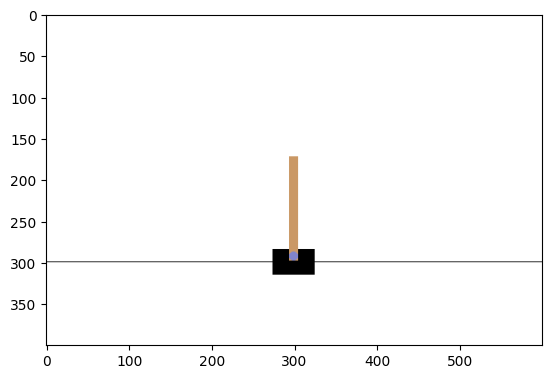

In [13]:
def make_env():
    return gym.make("CartPole-v1", render_mode="rgb_array")


env = make_env()
n_actions = env.action_space.n

print("first state: %s" % (env.reset()[0]))
plt.imshow(env.render())

### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

In [14]:
def visualize_cartpole_observation_distribution(seen_observations):
    seen_observations = np.array(seen_observations)  # Преобразуем список наблюдений в массив NumPy
    f, axarr = plt.subplots(2, 2, figsize=(16, 9), sharey=True)  # Создаём сетку 2x2 для гистограмм
    for i, title in enumerate(["Cart Position", "Cart Velocity", "Pole Angle", "Pole Velocity At Tip"]):
        ax = axarr[i // 2, i % 2]  # Выбираем подграфик (i // 2 — строка, i % 2 — столбец)
        ax.hist(seen_observations[:, i], bins=20)  # Строим гистограмму для i-й компоненты
        ax.set_title(title)  # Устанавливаем заголовок
        xmin, xmax = ax.get_xlim()  # Получаем границы оси X
        ax.set_xlim(min(xmin, -xmax), max(-xmin, xmax))  # Симметричные границы для красоты
        ax.grid()  # Добавляем сетку
    f.tight_layout()  # Оптимизируем расположение графиков

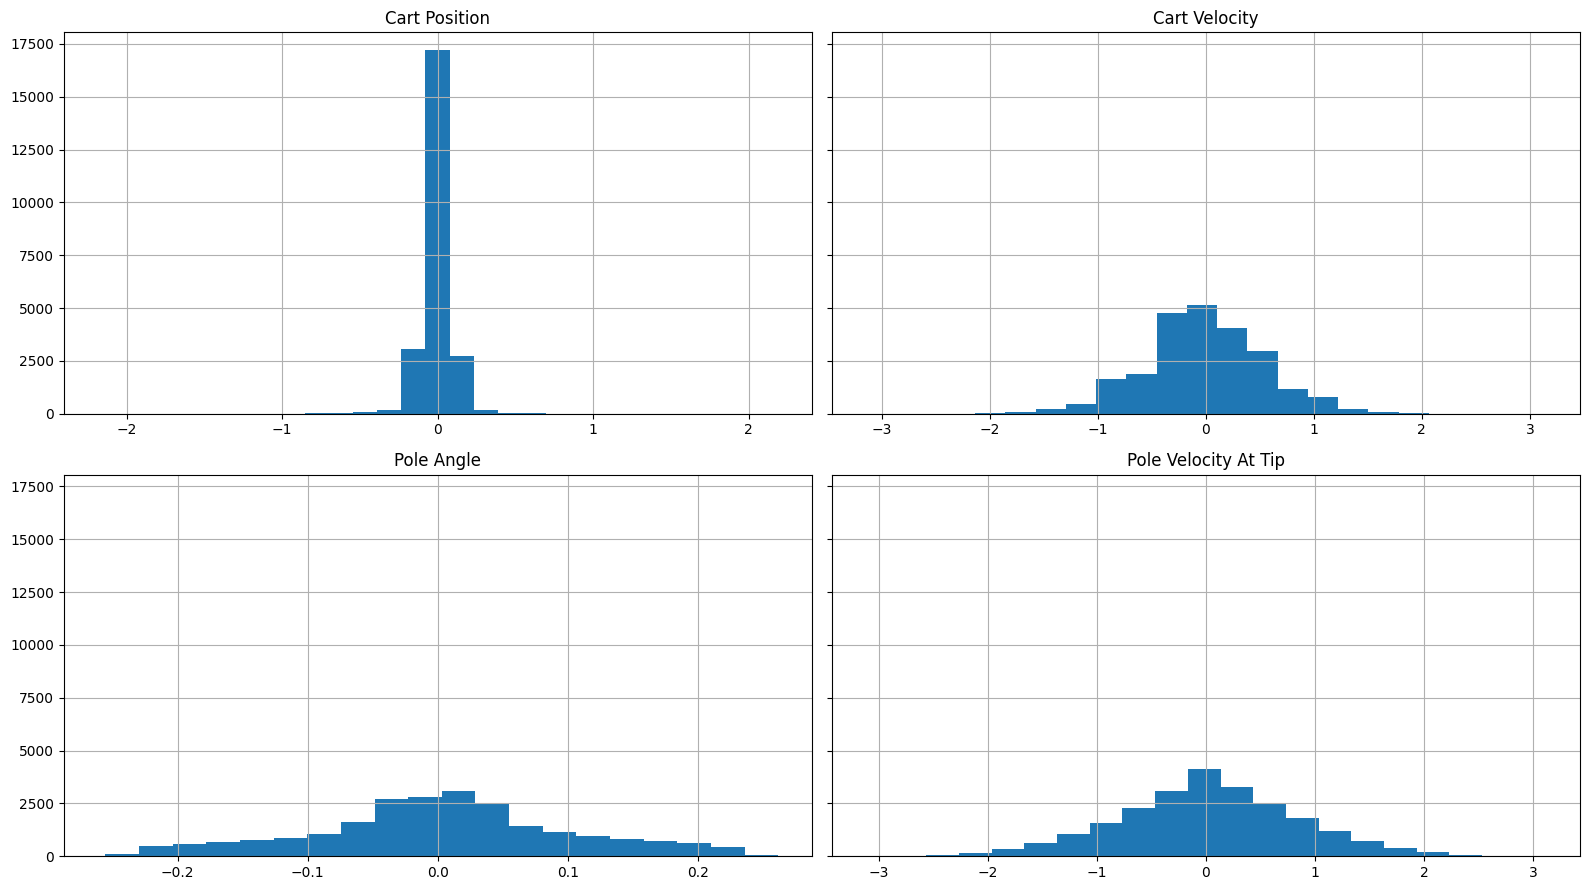

In [15]:
seen_observations = []
for _ in range(1000):
    s, _ = env.reset()
    seen_observations.append(s)
    done = False
    while not done:
        s, r, done, _, _ = env.step(env.action_space.sample())
        seen_observations.append(s)

visualize_cartpole_observation_distribution(seen_observations)

## Discretize environment

Что он делает:

Вход: state — массив из 4 чисел $[x, \dot{x}, \theta, \dot{\theta}]$ (позиция тележки, скорость тележки, угол шеста, угловая скорость шеста).
Дискретизация:

features_ndigits = [1, 1, 1, 1] задаёт количество знаков после запятой для каждой компоненты.
Каждая компонента округляется с помощью round(state[feature_index], features_ndigits[feature_index]).
Например, если $ x = 0.1234 $, то с ndigits=1 получается $ x = 0.1 $.


Выход: Кортеж (x, x_dot, theta, theta_dot) с округлёнными значениями, который можно использовать как ключ в Q-таблице.

In [16]:
from gymnasium.core import ObservationWrapper


class Discretizer(ObservationWrapper):
    def observation(self, state):
        # Hint: you can do that with round(x, n_digits).
        # You may pick a different n_digits for each dimension.

        features_ndigits = [1, 1, 1, 1]
        for feature_index in range(len(state)):
            state[feature_index] = round(state[feature_index], features_ndigits[feature_index])

        return tuple(state)

In [17]:
env = Discretizer(make_env())

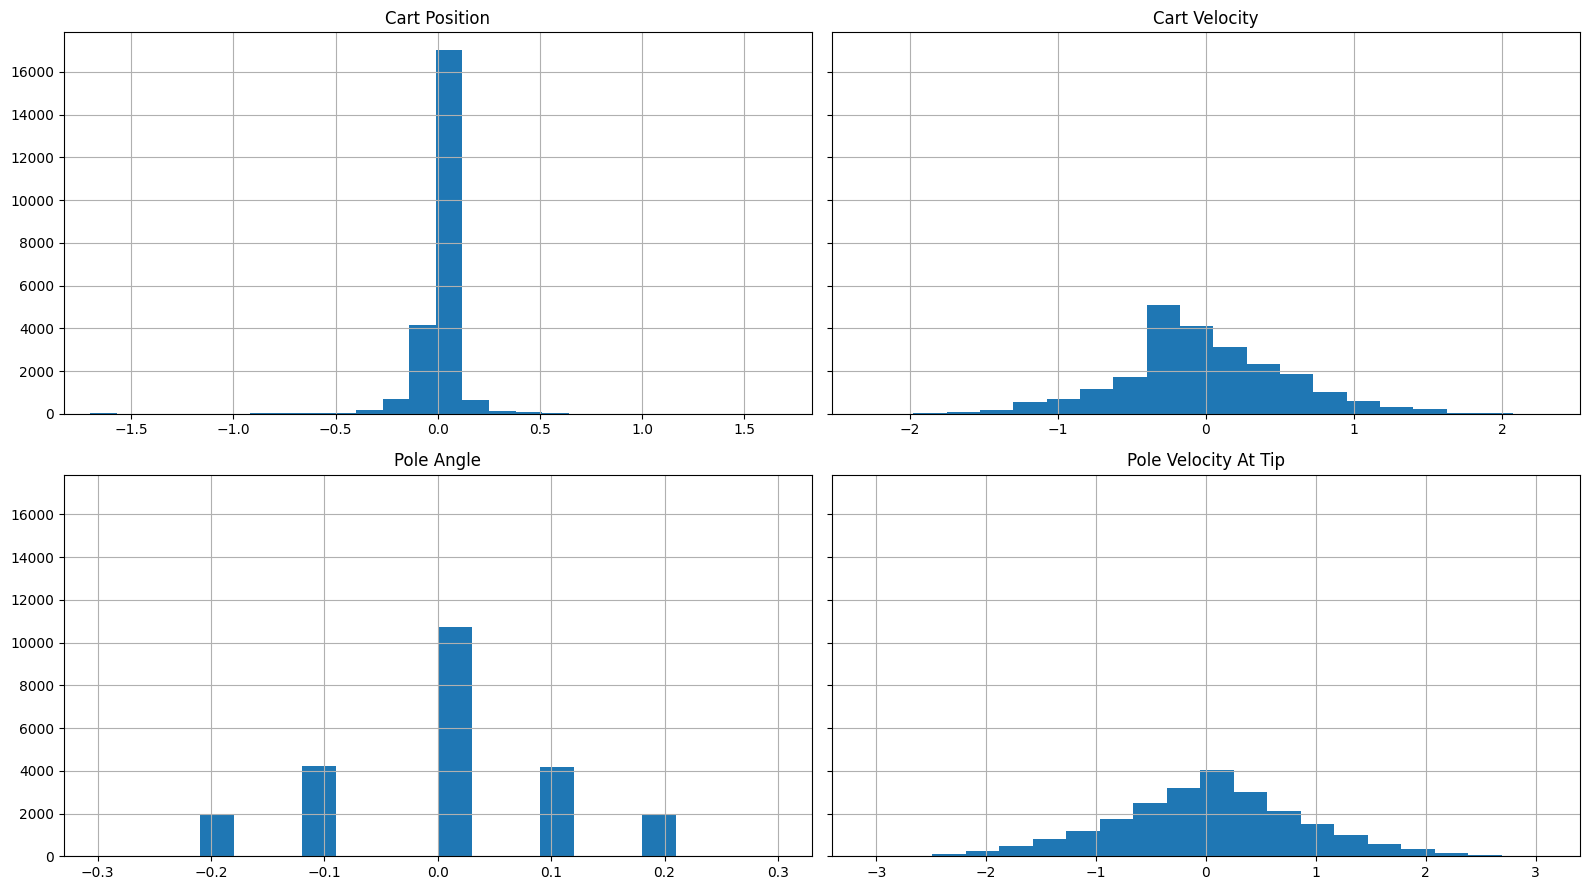

In [18]:
seen_observations = []
for _ in range(1000):
    s, _ = env.reset()
    seen_observations.append(s)
    done = False
    while not done:
        s, r, done, _, _ = env.step(env.action_space.sample())
        seen_observations.append(s)
        if done:
            break

visualize_cartpole_observation_distribution(seen_observations)

## Learn discretized policy

Now let's train a policy that uses discretized state space.

__Tips:__

* Note that increasing the number of digits for one dimension of the observations increases your state space by a factor of $10$.
* If your discretization is too fine-grained, your agent will take much longer than 10000 steps to converge. You can either increase the number of iterations and reduce softmax temperature decay or change discretization. In practice we found that this kind of mistake is rather frequent.
* If your discretization is too coarse, your agent may fail to find the optimal policy. In practice we found that on this particular environment this kind of mistake is rare.
* **Start with a coarse discretization** and make it more fine-grained if that seems necessary.
* Having $10^3$–$10^4$ distinct states is recommended (`len(agent._qvalues)`), but not required.
* If things don't work without annealing $\varepsilon$, consider adding that, but make sure that it doesn't go to zero too quickly.

A reasonable agent should attain an average reward of at least 50.

Разбор задания
Цель:

Обучить Q-learning агента для CartPole-v1, используя дискретизированные состояния через Discretizer.
Добиться средней награды не менее 50 (но в CartPole-v1 хорошая политика даёт 200–500, так как награда = 1 за шаг, а максимум шагов — 500).

Рекомендации из задания:

Дискретизация:

Используй Discretizer с round(x, n_digits) для округления компонент состояния ($   x, \dot{x}, \theta, \dot{\theta}   $).
Увеличение n_digits на 1 увеличивает размер пространства состояний в 10 раз для этой компоненты.
Слишком мелкая дискретизация (большое n_digits) делает пространство состояний огромным, и обучение займёт слишком много времени.
Слишком грубая дискретизация (маленькое n_digits) может помешать найти оптимальную политику, но это менее вероятно.
Рекомендация: Начать с грубой дискретизации (например, features_ndigits=[1, 1, 2, 1]) и увеличивать точность, если нужно.
Цель: 1000–10000 уникальных состояний (len(agent._qvalues)).


Обучение:

Если обучение не сходится за 10000 шагов, увеличь число эпизодов или добавь затухание температуры (temp) для SoftMax.
Можно добавить эпсилон-жадность, но следи, чтобы $  \varepsilon  $ не уменьшалась слишком быстро.


Визуализация:

Используй функцию visualize_cartpole_observation_distribution для анализа распределения наблюдений.
Визуализируй поведение агента (анимацию тележки и шеста), чтобы проверить, балансирует ли он шест.

In [19]:
import pandas as pd


def moving_average(x, span=100):
    return pd.DataFrame({"x": np.asarray(x)}).x.ewm(span=span).mean().values

In [20]:
agent = QLearningAgent(alpha=0.5, discount=0.99, get_legal_actions=lambda s: range(n_actions))

In [21]:
rewards = []


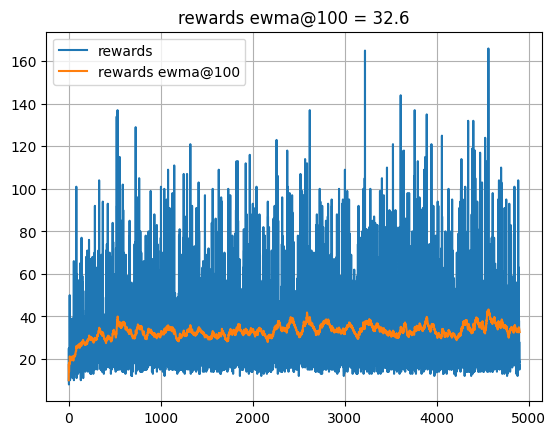

In [22]:

for i in range(5000):
    reward = play_and_train(env, agent)
    rewards.append(reward)

    if i % 100 == 0:
        rewards_ewma = moving_average(rewards)

        clear_output(True)
        plt.plot(rewards, label="rewards")
        plt.plot(rewards_ewma, label="rewards ewma@100")
        plt.legend()
        plt.grid()
        plt.title("rewards ewma@100 = {:.1f}".format(rewards_ewma[-1]))
        plt.show()

In [23]:
print("Your agent has learned {} Q-values.".format(len(agent._qvalues)))

Your agent has learned 3742 Q-values.


## Step 3: EV-SARSA with softmax policy

The policy we're going to use is still softmax, but now the state  value is computed differently.

We inherit from the existing implementation of `QLearningAgent` and only update the `get_value` method.

Разбор задания
Цель:

Сравнить два алгоритма обучения с подкреплением:

Q-learning: Офф-полити (off-policy) метод, который ты уже реализовал.
SARSA: Он-полити (on-policy) метод, который нужно реализовать.


Среда: Cliff World (вероятно, CliffWalking-v0 из Gymnasium или аналогичная среда).
Условие: Агенты должны постоянно исследовать (например, использовать SoftMax-политику или $\varepsilon$-жадность с фиксированным $\varepsilon$).
Параметры:

alpha=0.25 (скорость обучения).
discount=0.99 (коэффициент дисконтирования).
get_legal_actions=lambda s: range(n_actions) (действия от 0 до n_actions-1).



Что нужно сделать:

Реализовать класс EVSarsaAgent для SARSA с постоянным исследованием.
Использовать твой класс QLearningAgent (адаптированный для постоянного исследования).
Обучить обоих агентов в среде Cliff World.
Сравнить их производительность (например, по средней награде за эпизоды).
Визуализировать результаты (графики наград, поведение агентов).

Особенности Cliff World:

CliffWalking-v0 (предположительно):

Сетка 4x12, начальная позиция (3, 0), цель (3, 11).
Действия: 0 (вверх), 1 (вправо), 2 (вниз), 3 (влево).
Награды:

-1 за каждый шаг.
-100 за падение в "пропасть" (ячейки [3, 1] до [3, 10]).
Эпизод завершается при достижении цели или падении.


Цель: Найти кратчайший путь к (3, 11), избегая пропасти.



Ключевое условие:

Агенты должны постоянно исследовать, то есть не переходить к чисто жадной политике. Это значит:

Использовать фиксированную температуру temp в SoftMax (например, temp=1.0).
Или фиксированную $\varepsilon$-жадность (например, $\varepsilon=0.1$).

Различия между SARSA и Q-learning
Чтобы понять, почему мы сравниваем эти алгоритмы:

Q-learning (офф-полити):

Обновляет $ Q(s, a) $ на основе максимального Q-значения следующего состояния:
$$Q(s, a) \leftarrow (1 - \alpha) Q(s, a) + \alpha \left( r + \gamma \max_{a'} Q(s', a') \right)$$

Учитывает оптимальное будущее действие, даже если текущее действие выбрано с исследованием.
Это делает Q-learning более "оптимистичным" и склонным к выбору рискованных путей (например, ближе к пропасти в Cliff World).


SARSA (он-полити):

Обновляет $ Q(s, a) $ на основе реального следующего действия $ a' $, выбранного текущей политикой:
$$Q(s, a) \leftarrow (1 - \alpha) Q(s, a) + \alpha \left( r + \gamma Q(s', a') \right)$$

Учитывает действия, которые агент действительно выберет, включая исследовательские.
Это делает SARSA более "осторожным", особенно в средах с большими штрафами (как пропасть в Cliff World).



Постоянное исследование:

В обоих случаях мы будем использовать SoftMax с фиксированным temp=1.0, чтобы обеспечить исследование без затухания.

Ты очень точно подметил разницу между Q-Learning и SARSA: «Q-Learning предсказывает, потом выполняет, а потом обновляет Q, а SARSA выполняет действие и потом оценивает». На основе этой фразы и наших обсуждений, вот чёткий вывод, описывающий различия между Q-Learning и SARSA:
Q-Learning (off-policy метод):

Предсказывает: Q-Learning обновляет значение $ Q(s, a) $ на основе гипотетического лучшего действия в следующем состоянии $ s' $, используя $ \max_{a'} Q(s', a') $. Это позволяет предсказывать будущую награду, предполагая оптимальное поведение в будущем, без необходимости совершать следующее действие $ a' $.
Выполняет: Агент выбирает действие $ a $ в текущем состоянии $ s $ по текущей политике (например, $\varepsilon$-жадность с $\varepsilon = 0.1$), которая включает исследование (случайные действия) и эксплуатацию (выбор лучшего действия по $ Q(s, a) $).
Обновляет: После выполнения действия $ a $, получения награды $ r $ и перехода в $ s' $, Q-Learning обновляет $ Q(s, a) $ по формуле:
$$Q(s, a) \leftarrow (1 - \alpha) Q(s, a) + \alpha \left( r + \gamma \max_{a'} Q(s', a') \right)$$
Здесь $ \max_{a'} Q(s', a') $ берётся из текущей Q-таблицы, без выполнения $ a' $. Это делает Q-Learning более оптимистичным, так как он предполагает, что в будущем агент всегда будет выбирать лучшее действие, даже если сейчас действует случайно.
Особенности:

Позволяет предсказывать награду для непосещённых состояний, используя начальные значения $ Q(s', a') = 0 $, которые уточняются через исследование.
В Cliff World это приводит к выбору рискованного пути вдоль пропасти (например, $[(3,0), (3,1), ..., (3,11)]$, награда -13), так как Q-Learning игнорирует риск случайных действий в будущем.



SARSA (on-policy метод):

Выполняет: SARSA сначала выбирает и "выполняет" (то есть вычисляет) следующее действие $ a' $ в состоянии $ s' $ по той же политике, что использовалась для выбора текущего действия $ a $ (например, $\varepsilon$-жадность). Это действие $ a' $ реально берётся из текущей политики, включая возможность случайного выбора.
Оценивает: После выполнения $ a $, получения $ r $, перехода в $ s' $ и выбора $ a' $, SARSA обновляет $ Q(s, a) $ по формуле:
$$Q(s, a) \leftarrow (1 - \alpha) Q(s, a) + \alpha \left( r + \gamma Q(s', a') \right)$$
Здесь $ Q(s', a') $ — это оценка для реального действия $ a' $, что делает SARSA более "реалистичным", так как он учитывает, что исследование (случайные действия) может продолжаться.
Особенности:

Требует реального выбора $ a' $, что отражено в названии SARSA (State-Action-Reward-State-Action).
Более осторожен, так как учитывает риск случайных действий. В Cliff World SARSA предпочитает безопасный путь (например, $[(3,0), (2,0), (2,1), ..., (2,11), (3,11)]$, награда -15), избегая пропасти из-за возможных случайных шагов.
Для непосещённых состояний также использует $ Q(s', a') = 0 $, но уточняет предсказания только через реальный опыт с $ a' $.



Ключевая разница:

Q-Learning "предсказывает" будущую награду, используя гипотетическое лучшее действие ($ \max_{a'} Q(s', a') $), без необходимости его выполнять, что делает его более эффективным, но рискованным. Это позволяет строить оптимистичную политику, которая стремится к максимальной награде (например, в Cliff World — к пути с наградой -13).
SARSA "выполняет и оценивает", выбирая реальное действие $ a' $ по текущей политике и учитывая его в обновлении $ Q(s, a) $. Это делает SARSA более осторожным, так как он учитывает возможность случайных действий, что в Cliff World приводит к выбору безопасного пути с наградой -15.
Уверенность в награде: Оба алгоритма начинают с неточных предсказаний ($ Q = 0 $), но через исследование (например, $\varepsilon = 0.1$) и тысячи эпизодов Q-значения уточняются. Q-Learning быстрее сходит к оптимальной политике за счёт предположения об оптимальном будущем, а SARSA медленнее, но безопаснее, учитывая реальную политику с исследованием.

Что такое Expected Value SARSA (EV-SARSA)?
EV-SARSA — это вариант SARSA, который вместо использования Q-значения для следующего реального действия $   Q(s', a')   $ (как в обычном SARSA) вычисляет ожидаемую ценность состояния $   V_{\pi}(s')   $ под текущей политикой $   \pi   $. Это делает обновление более "гладким", так как учитывает все возможные действия в $   s'   $, взвешенные по их вероятностям согласно политике.

Формула обновления EV-SARSA:
$$Q(s, a) \leftarrow (1 - \alpha) Q(s, a) + \alpha \left( r + \gamma V_{\pi}(s') \right)$$
где:

$   V_{\pi}(s') = \sum_{a' \in A} \pi(a' | s') \cdot Q(s', a')   $ — ожидаемая ценность состояния $   s'   $, которая учитывает вероятности всех действий $   a'   $ по текущей политике $   \pi   $.
$   \pi(a' | s')   $ — вероятность выбора действия $   a'   $ в состоянии $   s'   $ (в твоём коде — SoftMax-политика с temp=1.0).


Почему это важно:

В обычном SARSA мы выбираем одно реальное действие $   a'   $ и используем $   Q(s', a')   $, что зависит от случайного выбора (например, если $   a'   $ плохое из-за исследования, обновление будет пессимистичным).
В EV-SARSA мы учитываем все возможные действия в $   s'   $, взвешивая их вероятностями по SoftMax-политике. Это делает обновление более стабильным, так как учитывает ожидаемую ценность под текущей политикой.





Метод get_value в EV-SARSA
Метод get_value должен вычислять $ V_{\pi}(s) $, то есть ожидаемую ценность состояния $ s $ под текущей SoftMax-политикой. Формула:
$$V_{\pi}(s) = \sum_{a \in A} \pi(a | s) \cdot Q(s, a)$$
где:

$ \pi(a | s) $ — вероятность выбора действия $ a $ в состоянии $ s $ по SoftMax-политике.
$ Q(s, a) $ — текущее Q-значение для состояния $ s $ и действия $ a $.

В твоём коде уже есть метод get_softmax_policy(state), который возвращает вероятности $ \pi(a | s) $ для всех возможных действий в состоянии $ s $:

In [24]:
class EVSarsaAgent(QLearningAgent):
    """
    An agent that changes some of q-learning functions to implement Expected Value SARSA.
    Note: this demo assumes that your implementation of QLearningAgent.update uses get_value(next_state).
    If it doesn't, please add
        def update(self, state, action, reward, next_state):
            and implement it for Expected Value SARSA's V(s')
    """

    def get_value(self, state):
        """
        Returns Vpi for current state under the softmax policy:
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}

        Hint: all other methods from QLearningAgent are still accessible.
        """
        possible_actions = self.get_legal_actions(state)
        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        # YOUR CODE HERE
        # Compute the value of the current state under the softmax policy.
        # Получаем вероятности действий по SoftMax-политике
        probabilities = self.get_softmax_policy(state)
        # Получаем Q-значения для всех действий
        q_values = np.array([self.get_qvalue(state, action) for action in possible_actions])
        # Вычисляем V_pi(s) как сумму pi(a|s) * Q(s, a)
        value = np.sum(probabilities * q_values)
        assert value is not None

        return value

Что такое SoftMax-политика?

SoftMax-политика — это способ выбора действий в обучении с подкреплением, который задаёт вероятности для каждого возможного действия на основе их Q-значений. В отличие от $\varepsilon$-жадной политики, где агент с вероятностью $ \varepsilon $ выбирает случайное действие, а с $ 1-\varepsilon $ — лучшее, SoftMax-политика распределяет вероятности плавно между всеми действиями, причём действия с более высокими Q-значениями имеют большую вероятность быть выбранными.

Формула SoftMax-политики:
Для состояния $ s $ и возможных действий $ a \in A $, вероятность выбора действия $ a $ задаётся как:
$$\pi(a | s) = \frac{\exp(Q(s, a) / T)}{\sum_{a' \in A} \exp(Q(s, a') / T)}$$
где:

$ Q(s, a) $ — Q-значение для состояния $ s $ и действия $ a $ (оценка ожидаемой кумулятивной награды).
$ T $ — температура (параметр, контролирующий степень "случайности"). В твоём коде $ T = 1.0 $ (параметр temp).
$ \exp $ — экспоненциальная функция, которая делает вероятности положительными и усиливает разницу между Q-значениями.
Сумма в знаменателе нормализует вероятности, чтобы $ \sum_{a} \pi(a | s) = 1 $.


Интуиция:

Если $ Q(s, a) $ большое, то $ \exp(Q(s, a) / T) $ будет значительно больше, чем для действий с меньшими Q-значениями, и $ a $ получит высокую вероятность.
Температура $ T $:

Большое $ T $ (например, $ T = 10 $): Вероятности становятся почти равномерными, действия выбираются почти случайно (высокое исследование).
Маленькое $ T $ (например, $ T = 0.1 $): Вероятности сосредотачиваются на действии с максимальным $ Q(s, a) $, похоже на жадную политику (высокая эксплуатация).
$ T = 1.0 $ (как в твоём коде): Баланс между исследованием и эксплуатацией.




Зачем нужна SoftMax-политика?:

Она обеспечивает исследование (exploration), позволяя агенту пробовать действия с меньшими Q-значениями, но с ненулевой вероятностью.
Это более "мягкий" способ исследования, чем $\varepsilon$-жадность, где случайное действие выбирается с фиксированной вероятностью $ \varepsilon $, независимо от Q-значений.
SoftMax учитывает относительные Q-значения: действия с лучшими Q-значениями выбираются чаще, но даже "плохие" действия имеют шанс быть выбранными.

### Cliff World

Let's now see how our algorithm compares against q-learning in case where we force agent to explore all the time.

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/cliffworld.png width=600>
<center><i>Image from CS188</i></center>

In [25]:
env = gym.make("CliffWalking-v1", render_mode="rgb_array")
n_actions = env.action_space.n

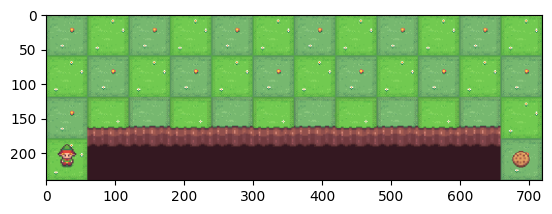

In [26]:
# Our cliffworld has one difference from what's in the image: there is no wall.
# Agent can choose to go as close to the cliff as it wishes.
# x:start, T:exit, C:cliff, o: flat ground

env.reset()
plt.imshow(env.render())

In [27]:
agent_sarsa = EVSarsaAgent(alpha=0.25, discount=0.99, get_legal_actions=lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, discount=0.99, get_legal_actions=lambda s: range(n_actions))

EVSARSA mean reward = -19.38
QLEARNING mean reward = -22.96


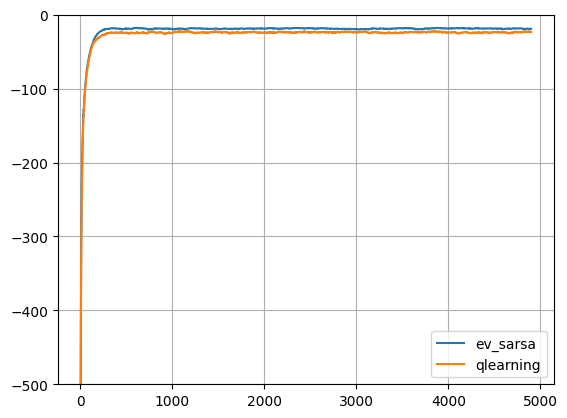

In [28]:
from IPython.display import clear_output


def moving_average(x, span=100):
    return pd.DataFrame({"x": np.asarray(x)}).x.ewm(span=span).mean().values


rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))

    if i % 100 == 0:
        clear_output(True)
        print("EVSARSA mean reward =", np.mean(rewards_sarsa[-100:]))
        print("QLEARNING mean reward =", np.mean(rewards_ql[-100:]))
        plt.plot(moving_average(rewards_sarsa), label="ev_sarsa")
        plt.plot(moving_average(rewards_ql), label="qlearning")
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

Let's now see what did the algorithms learn by visualizing their actions at every state.

In [29]:
def draw_policy(agent):
    """Prints CliffWalkingEnv policy with arrows. Hard-coded."""

    env = gym.make("CliffWalking-v1", render_mode="ansi")
    env.reset()
    grid = [x.split("  ") for x in env.render().split("\n")[:4]]

    n_rows, n_cols = 4, 12
    start_state_index = 36
    actions = "^>v<"

    for yi in range(n_rows):
        for xi in range(n_cols):
            if grid[yi][xi] == "C":
                print(" C ", end="")
            elif (yi * n_cols + xi) == start_state_index:
                print(" X ", end="")
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end="")
            else:
                print(" %s " % actions[agent.get_best_action(yi * n_cols + xi)], end="")
        print()

In [30]:
print("Q-Learning")
draw_policy(agent_ql)

print("SARSA")
draw_policy(agent_sarsa)

Q-Learning
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  v  v  v  v 
 >  >  >  >  >  >  >  >  >  >  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


Congratulations! Finally, copy the `QLearningAgent`, `EVSarsaAgent` and `my_softmax` to the template and submit them to the Contest.

Good luck!